In [423]:
import funcy
import numpy as np
import pandas as pd
import collections
import funcy
import os
import datetime
import matplotlib 
import matplotlib.pyplot as plt
import networkx as nx


from dev import (LOCAL_DB, DATA_DIR, DROPBOX_DIR, DEV_COLLAB_FNAME, DEV_CHANGES_FNAME, 
                         DEV_CONTR_BY_FILE_FNAME, DEV_RANKING_FNAME, RAW_FNAME)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

DATETIME_FMT = '%Y-%m-%d %H:%M:%S'
EXPORT_CSV=True
GITHUB_BAD_EMAILS = ('noreply@github.com',)

In [35]:
# read in developer collab file with number/who people they worked with, first and last engagement
# then add in total number of files edit, total only they worked on, total authored and commited

# get average age of files they commited
# total lines of code added/deleted
# average code complexity/percentile relative to that file
# do these all in percentiles as well and then rank by 

In [447]:
def import_raw(filepath, datetime_fmt=DATETIME_FMT):
    df3 = pd.read_csv(filepath)
    if 'Unnamed: 0' in df3:
        del df3['Unnamed: 0']
    # delete these from the ranking
    del df3['raw_diff']
    del df3['sha1']
    del df3['git_hash']
    # convert timestamp to a time value
    df3['timestamp'] = df3.timestamp.apply(lambda x: pd.datetime.strptime(x, datetime_fmt))
    # create a date column
    df3['date'] = df3.timestamp.apply(lambda x: x.date())
    return df3

In [432]:
def get_min_max_engagement(df, type_id):
    # if want first and last commit engagement, type id should be commiter id
    type_name = type_id.split('_')[0]
    comm_time = df.sort_values(
        [type_id, 'timestamp']).groupby([type_id]).agg({'timestamp': [np.min, np.max],
                                                               'commit_id' : 'nunique',
                                                               'diff_id': 'nunique'})
    comm_time.columns = [
        'first_{}_engagement'.format(type_name), 'last_{}_engagement'.format(type_name),
        'num_{}_commits'.format(type_name), 'num_{}_diffs'.format(type_name)
    ]

    comm_time['len_{}_engagement'.format(type_name)] = comm_time[
        'last_{}_engagement'.format(type_name)] - comm_time['first_{}_engagement'.format(type_name)]
    return comm_time

In [433]:
def get_author_comm_collabs(df3):
    # collaborations stats
    # for each author, I want to keep track of who commits their diffs
    # who else works on the same files as them
    # not a groupby object possibility, need to do a first/last dataframe
    author_comm_pairs = df3[['author_id', 'author_email', 'commiter_id', 'commiter_email', 'timestamp']].values

    # filter for pairs that are different
    collabs = list(filter(lambda x: x[0]!=x[2], author_comm_pairs))

    # for each author, find number of commits
    collab_df = pd.DataFrame(
        collabs, columns=['author_id', 'author_email', 'commiter_id', 'commiter_email', 'timestamp']).drop_duplicates()

    collab2 = collab_df[['author_id', 'commiter_id']].sort_values('author_id').drop_duplicates().values
    
    d = collections.defaultdict(list)
    c = collections.defaultdict(list)
    for auth_id, collab in collab2:
        d[auth_id].append(collab)
        c[collab].append(auth_id)
    l = list(d.keys())
    l.extend(c.keys())
    
    # turn into a set to remove duplicate ids
    all_ids = np.array(list(set(l)))
    dev = pd.DataFrame(index=all_ids, columns=[
        'people_who_committer_their_commits', 'people_who_authored_commits_they_commited'])
    dev.index.name = 'author_id'
    dev['people_who_committer_their_commits'] = dev.index.map(lambda x: d[x])
    dev['people_who_authored_commits_they_commited'] = dev.index.map(lambda x: c[x])
    # add number of people who they co-authored/commited with
    dev['num_people_who_committer_their_commits'] = dev['people_who_committer_their_commits'].apply(lambda x: len(x))
    dev['num_people_who_authored_commits_they_commited'] = dev['people_who_authored_commits_they_commited'].apply(lambda x: len(x))
    dev['num_people_who_committer_their_commits'] = dev['num_people_who_committer_their_commits'].fillna(0)
    dev['num_people_who_authored_commits_they_commited'] = dev['num_people_who_authored_commits_they_commited'].fillna(0)
    return dev

In [520]:
def get_dev_stats(df3):
    # previously generated the DEV_CHANGES_FNAME
    
    # used to have number of edit locations, but realized it was not being correctly reported (always equal to num diffs)
    # first, aggregate number of additions, deletions, deletions, renames by author
    auths = df3.sort_values(['author_id', 'timestamp']).groupby(['author_id']).agg({
    'additions': np.sum, 'deletions': np.sum, 'net_change': np.mean,
    'code_complexity_median': np.mean, 'code_complexity_max': np.max,
    'filename_old': 'nunique',  'diff_id': 'nunique', 'commit_id': 'nunique', 
    'is_rename': np.sum, 'is_deletion': np.sum, 'is_new': np.sum}).rename(columns={
        'additions': 'total_additions', 
        'deletions': 'total_deletions', 'net_change': 'average_net_change',
        'code_complexity_median':'mean_of_code_complexity_median', 
        'filename_old': 'num_unique_files_changed', 
        'is_rename': 'num_renames', 'is_deletion': 'num_deletions',
        'is_new': 'num_new_files', 'commit_id': 'num_commits', 'diff_id': 'num_total_diffs'})
    auths['net_code'] = auths['total_additions'] - auths['total_deletions']
    
    # gets repo totals of lines, deletions, renames etx
    repo_totals = df3[['additions', 'deletions', 'is_rename', 'is_deletion', 'is_new']].sum(axis=0)
    repo_totals['repo_total_net_code'] = repo_totals.additions - repo_totals.deletions
    auths['repo_total_additions'] = repo_totals['additions']
    auths['repo_total_deletions'] = repo_totals['deletions']
    auths['repo_total_renames'] = repo_totals['is_rename']
    auths['repo_total_file_deletions'] = repo_totals['is_deletion']
    auths['repo_total_file_creations'] = repo_totals['is_new']
    auths['repo_total_net_code'] = repo_totals['repo_total_net_code']

    # calculate percentage of new code added
    
    auths['pct_total_additions'] = auths['total_additions']/auths['repo_total_additions']
    auths['pct_total_deleted'] = auths['total_deletions']/auths['repo_total_deletions']
    auths['pct_total_lines'] = auths['net_code']/auths['repo_total_net_code']
    return auths, repo_totals
 

In [494]:
def get_file_dev_stats(df3):
    # get number of additions/deletions to each file as of a certian date
    # this creates what was previously known of as the FILE_STATS_FNAME file

    # this will be merged into first_dev data set that tells us about the first author and commiter for each file
    # as well as number of unique developers, commiters and lines added per file
    file_dev = df3.sort_values(
        ['canonical_name', 'author_id', 'timestamp']).groupby(['canonical_name']).agg({
        'author_id': 'nunique', 'commiter_id': 'nunique', 
        'additions': np.sum, 'deletions': np.sum,  'net_change': np.sum, 'code_complexity_max': np.max, 
        'timestamp': np.max}
            ).rename(columns={
            'author_id': 'distinct_authors','commiter_id': 'num_unique_commiters',
            'additions': 'total_additions', 'deletions': 'total_deletions',
            'net_change': 'total_code', 'code_complexity_max': 'file_level_code_complexity_max', 
            'timestamp': 'time_last_change'})
    
    # then, for each author on the file, count their contribution to the file
    file_dev_lines = df3.sort_values(
            ['canonical_name', 'author_id', 'timestamp']).groupby(['canonical_name', 'author_id']).agg({
            'additions': np.sum, 'deletions': np.sum,  'net_change': np.sum, 'code_complexity_max': np.max,
            'timestamp': np.max}).rename(columns={
            'timestamp': 'time_author_last_change',
    })
    # merge file level stats with file-author level stats
    file_stats2 = file_dev_lines.merge(right=file_dev, left_index=True, right_index=True, how='outer')
    print('file level stats shape ', file_dev.shape)
    print('file author level stats shape ', file_dev_lines.shape)
    print('merged file shape ', file_stats2.shape)
    
    # count files solo authored by each developer
    file_stats2.loc[:, 'solo_authored'] = 0
    file_stats2.loc[file_stats2.distinct_authors==1, 'solo_authored'] = 1

    # count files where author has authored the max complexity
    file_stats2['authored_max_complexity'] = 0
    file_stats2.loc[((file_stats2.code_complexity_max==file_stats2.file_level_code_complexity_max) & (
        file_stats2.file_level_code_complexity_max > 0)), 'authored_max_complexity'] = 1

    # calculate percent of additions each person has contributed, fill missing with 0s
    file_stats2['pct_additions'] = file_stats2['additions']*100.0/file_stats2['total_additions']
    file_stats2['pct_deletions'] = file_stats2['deletions']*100.0/file_stats2['total_deletions']
    file_stats2[['pct_additions', 'pct_deletions']] = file_stats2[['pct_additions', 'pct_deletions']].fillna(0)

    # flag for more than 50% additions/deletions
    file_stats2['more_than_50pct_additions'] = file_stats2.pct_additions.apply(lambda x: 1 if x > 50 else 0)
    file_stats2['more_than_50pct_deletions'] = file_stats2.pct_deletions.apply(lambda x: 1 if x > 50 else 0)
    
   # calculate if person was the last to change a file
    file_stats2['last_change'] = file_stats2.apply(
        lambda x: 1 if x.time_author_last_change==x.time_last_change else 0, axis=1)
    # calculate age of the file since last change
    file_stats2['file_age'] = file_stats2['time_last_change'].apply(lambda x: (pd.datetime.now() - x).days)
    return file_stats2


In [495]:
def get_first_engagement(x):
    comm = x['first_commiter_engagement']
    auth = x['first_author_engagement']
    if pd.isnull(comm):
        return 'auth'
    if pd.isnull(auth) or comm < auth:
        return 'comm'
    return 'auth'
  

def get_last_engagement(x):
    comm = x['last_commiter_engagement']
    auth = x['last_author_engagement']
    if pd.isnull(comm):
        return 'auth'
    if pd.isnull(auth) or comm > auth:
        return 'comm'
    return 'auth'


def get_time_engaged(x):
    zero = datetime.datetime.strptime('2000-01-01 00:00:00',DATETIME_FMT )
    first = np.nanmin(x[['first_commiter_engagement', 'first_author_engagement']].fillna(pd.datetime.now()))
    last = np.nanmax(x[['last_commiter_engagement', 'last_author_engagement']].fillna(zero))
    if pd.isnull(first) and pd.isnull(last):
        return np.nan
    diff = last-first
    return diff.astype('timedelta64[D]')
    print(diff)
    return diff.days

In [521]:
def get_rank_files(df, as_of_date, start_date=None):
    if not isinstance(as_of_date, pd.Timestamp):
         as_of_date = pd.datetime.strptime(as_of_date, '%Y-%m-%d')
    if start_date is not None and start_date is not isinstance(start_date, pd.Timestamp):
         start_date = pd.datetime.strptime(start_date, '%Y-%m-%d')
    if start_date is not None:
        time_mask = ((df.timestamp >= start_date) & (df.timestamp < as_of_date))
    else:
        time_mask = (df.timestamp < as_of_date)
        
    df_short = df[time_mask]
    collab = get_author_comm_collabs(df_short)

    auth_time = get_min_max_engagement(df_short, 'author_id')
    # not that commit_id is id for each commit, so make sure you don't use that one
    comm_time = get_min_max_engagement(df_short, 'commiter_id')

    collab2 = collab.merge(right=auth_time, left_index=True, right_index=True, how='outer')
    collab3 = collab2.merge(right=comm_time, left_index=True, right_index=True, how='outer')

    auths, repo_stats = get_dev_stats(df_short)
    dev_file = get_file_dev_stats(df_short)
    
    # for each developer count total number of solo authored, files with max complexity, more than 50pct additions,
    # more than 50 pct deletions, last change average pct additions, 
    # avg pct deletions, file age, advg distinct authors
    dev_file2 = dev_file.reset_index().sort_values(['author_id', 'canonical_name']).groupby('author_id').agg({
        'canonical_name': 'nunique', 'distinct_authors': np.mean, 'pct_additions': np.mean,
        'pct_deletions': np.mean, 
        'file_age': np.mean,
        'solo_authored': np.sum, 'authored_max_complexity': np.sum, 'more_than_50pct_additions': np.sum,
        'more_than_50pct_deletions': np.sum, 'last_change': np.sum, 
        }).rename(columns={
        'canonical_name': 'number_different_files_changed',
        'distinct_authors': 'avg_num_distinct_authors_per_file',
        'pct_additions': 'average_pct_additions', 'pct_deletions': 'avg_pct_deletions',
        'file_age': 'avg_file_age',
        'solo_authored': 'total_files_solo_authored',
        'authored_max_complexity': 'total_files_with_max_complexity',
        'more_than_50pct_aMdditions': 'total_files_more_than_50pct_additions', 
        'more_than_50pct_deletions': 'total_files_more_than_50pct_deletions', 
        'last_change': 'total_files_with_last_change'
    })
 
    collab4 = collab3.merge(right=auths, left_index=True, right_index=True, how='outer')
    collab5 = collab4.merge(right=dev_file2, left_index=True, right_index=True, how='outer')
    print(collab3.shape)
    print(auths.shape)
    print(collab4.shape)
    print(dev_file2.shape)
    print(collab5.shape)
    collab5.loc[:, 'type_first_engagement'] = collab5.apply(get_first_engagement, axis=1)
    collab5.loc[:, 'type_last_engagement'] = collab5.apply(get_last_engagement, axis=1)
    collab5.loc[:, 'days_involved'] = collab5.apply(get_time_engaged, axis=1)
    
    # merge in author ids and emails
    unique_devs = pd.concat([df_short[[
    'author_email', 'author_id']].rename(
        columns={'author_email': 'email', 'author_id': 'developer_id'}),
           df_short[['commiter_email', 'commiter_id']].rename(
        columns={'commiter_email': 'email', 'commiter_id': 'developer_id'})]).drop_duplicates().set_index(
        'developer_id')
   
    c6 = collab5.merge(right=unique_devs, left_index=True, right_index=True, how='left')
    c6.index.name = 'developer_id'
    c6[
    ['len_commiter_engagement', 'len_author_engagement', 'days_involved']] = c6[
        ['len_commiter_engagement', 'len_author_engagement', 'days_involved']].fillna(0)
    
    split_days = lambda x: x.days
    c6.days_involved = c6.days_involved.apply(split_days)
    c6.len_author_engagement = c6.len_author_engagement.apply(split_days)
    c6.len_commiter_engagement = c6.len_commiter_engagement.apply(split_days)
    print(c6.shape)
    return c6



In [522]:
def rank_metrics(df, cols_to_rank=None):
    if not cols_to_rank:
        cols_to_rank = [
            c for c in df.columns if not c.endswith(
                '_engagement') and not c.startswith('people_') and not c.startswith('repo_') and c not in ('email', 'name', 'developer_id', 'author_id')]
    print('ranking the following columns ', cols_to_rank)
    # note that we use ascending = False becase we want people iwth largest number of things to get higher ranks
    ranks = df[cols_to_rank].apply(lambda x: x.rank(ascending=False), axis=0)
    ranks.columns = ['rank_{}'.format(x) for x in ranks.columns]
    # axis=1 apply function to each row
    ranks['avg_rank'] = ranks[[c for c in ranks.columns if c.startswith('rank_')]].apply(np.mean, axis=1)
    ranks['rank'] = ranks.avg_rank.rank()
    return ranks.sort_values('rank', ascending=True)
    

In [523]:
# helper function to combine lists, which may be empty or np.nana, which is why we can't do a traditional analysis of lists
def combine_edges(l1):
    if not isinstance(l1, list) and pd.isnull(l1):
        return []
    return l1

def combine_lists(l1, l2):
    return list(set(l1 + l2))

def create_adj_dict_of_lists(relationship_df):
    # rank df should have columns with ids of people who authored commits
     #fill na columns with empty lists for these specific values - except can't do it with a list sad
    # get most recent collaboration information
    graph_edges = relationship_df[[
        'developer_id', 'rank_time',
            'people_who_committer_their_commits',
            'people_who_authored_commits_they_commited']].sort_values(
            ['developer_id', 'rank_time'], ascending=False).groupby(
            'developer_id').agg({'people_who_authored_commits_they_commited': funcy.first,
                        'people_who_committer_their_commits': funcy.first})

    z = zip(graph_edges.index, graph_edges.people_who_authored_commits_they_commited.values,
            graph_edges.people_who_committer_their_commits.values)
    node_edges = {dev_id: combine_lists(combine_edges(x), combine_edges(y)) for dev_id, x, y in z }
    empty_nodes = [x for x,y in node_edges.items() if len(y) == 0]

    print('PERCENT EMPTY NODES ', len(empty_nodes)/len(node_edges))
    return node_edges

In [524]:
def create_graph(rank_df):
    # sort connectivity measures by network centrality value
    # sorted(centrality_coeffs.items(), key=lambda x: x[1], reverse=True)
    node_edges = create_adj_dict_of_lists(rank_df)
    # create the networkx graph from a dict of lists
    g = nx.convert.from_dict_of_lists(node_edges)
    centrality_coeffs = nx.eigenvector_centrality(g)
    pagerank_vals = nx.pagerank(g)
    return centrality_coeffs, pagerank_vals, g

    

def graph_network_save_pdf(g, title_str):
    f = plt.figure(1, figsize=(12, 12))
    ax = f.add_subplot(111)

    # the font option control node lables, alpha controls degree of transparency
    nx.draw_networkx(
        g, with_labels=True, nodelist=nodes, alpha=.2, edge_color='b', 
            pos=nx.kamada_kawai_layout(g), node_size=60, font_size=16, font_weight='bold', ax=ax)
    plt.title(title_str)
    plt.savefig(os.path.join(DROPBOX_DIR, 'Networks/{}.pdf'.format(title_str)))
    plt.show()
    

In [525]:
IMPORTANT_COLS = ['network_centrality', 'total_additions', 'total_deletions', 'code_complexity_max',
          'num_unique_files_changed',  'num_renames','num_new_files', 'num_deletions',
           'num_total_diffs', 'num_commits', 'days_involved']

def compute_ranks(df, as_of_date, cols_to_rank=IMPORTANT_COLS):
    df1 = get_rank_files(df, as_of_date)
    # remove bad developers
    df2 = df1.loc[~df1.email.isin(GITHUB_BAD_EMAILS)]
    df2.loc[:, 'rank_time'] = as_of_date
    # need to reset index so that developer id is a columns
    centrality_coeffs, pagerank_vals, g = create_graph(df2.reset_index())
    df2.loc[:, 'network_centrality'] = pd.Series(
            df2.index.map(lambda x: centrality_coeffs.get(x, 0)), index=df2.index)
    df2.loc[:, 'pagerank'] = df2.index.map(lambda x: pagerank_vals.get(x, 0))
    ranks = rank_metrics(df2, cols_to_rank)
    df3 = df2.merge(right=ranks, left_index=True, right_index=True) 
    df4 = df3.reset_index()
    print(df4.shape)
    return df4.sort_values('rank')

In [519]:
# ACTUAL CODE

In [448]:
df3 = import_raw(os.path.join(DROPBOX_DIR, RAW_FNAME))

# df3.to_excel(os.path.join(DROPBOX_DIR, 'jsipfs_data_to_view.xlsx'), index=False)

In [526]:
df5 = compute_ranks(df3, '2018-07-01')

file level stats shape  (930, 7)
file author level stats shape  (1942, 5)
merged file shape  (1942, 12)
(88, 14)
(87, 21)
(88, 35)
(85, 10)
(88, 45)
(88, 49)


/Users/Lraymond/Python/OS_research/OSresearch/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Lraymond/Python/OS_research/OSresearch/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


PERCENT EMPTY NODES  0.12643678160919541
ranking the following columns  ['network_centrality', 'total_additions', 'total_deletions', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_new_files', 'num_deletions', 'num_total_diffs', 'num_commits', 'days_involved']
(87, 66)


In [420]:
if EXPORT_CSV:
   # df5.to_excel(os.path.join(DROPBOX_DIR, 'overall_developer_rankings.xlsx'))

In [514]:
date_range = pd.date_range(start='06/01/2014', end='2018-07-01', freq='M')

dfs = []
for d in date_range:
    dfs.append(compute_ranks(df3, d))

file level stats shape  (103, 7)
file author level stats shape  (103, 5)
merged file shape  (103, 12)
(1, 14)
(1, 21)
(1, 35)
(1, 10)
(1, 45)
(1, 49)
PERCENT EMPTY NODES  1.0
ranking the following columns  ['network_centrality', 'total_additions', 'total_deletions', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_new_files', 'num_deletions', 'num_total_diffs', 'num_commits', 'days_involved']
(1, 66)
file level stats shape  (115, 7)
file author level stats shape  (115, 5)
merged file shape  (115, 12)
(1, 14)
(1, 21)
(1, 35)
(1, 10)
(1, 45)
(1, 49)
PERCENT EMPTY NODES  1.0
ranking the following columns  ['network_centrality', 'total_additions', 'total_deletions', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_new_files', 'num_deletions', 'num_total_diffs', 'num_commits', 'days_involved']
(1, 66)
file level stats shape  (117, 7)
file author level stats shape  (117, 5)
merged file shape  (117, 12)
(2, 14)
(2, 21)
(2, 35)
(2, 10)
(2, 45)
(2, 49

file level stats shape  (355, 7)
file author level stats shape  (389, 5)
merged file shape  (389, 12)
(8, 14)
(8, 21)
(8, 35)
(8, 10)
(8, 45)
(8, 49)
PERCENT EMPTY NODES  1.0
ranking the following columns  ['network_centrality', 'total_additions', 'total_deletions', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_new_files', 'num_deletions', 'num_total_diffs', 'num_commits', 'days_involved']
(8, 66)
file level stats shape  (392, 7)
file author level stats shape  (495, 5)
merged file shape  (495, 12)
(10, 14)
(10, 21)
(10, 35)
(10, 10)
(10, 45)
(10, 49)
PERCENT EMPTY NODES  0.8
ranking the following columns  ['network_centrality', 'total_additions', 'total_deletions', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_new_files', 'num_deletions', 'num_total_diffs', 'num_commits', 'days_involved']
(10, 66)
file level stats shape  (423, 7)
file author level stats shape  (623, 5)
merged file shape  (623, 12)
(15, 14)
(15, 21)
(15, 35)
(15, 10)
(15

/Users/Lraymond/Python/OS_research/OSresearch/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Lraymond/Python/OS_research/OSresearch/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


ranking the following columns  ['network_centrality', 'total_additions', 'total_deletions', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_new_files', 'num_deletions', 'num_total_diffs', 'num_commits', 'days_involved']
(16, 66)
file level stats shape  (468, 7)
file author level stats shape  (722, 5)
merged file shape  (722, 12)
(18, 14)
(17, 21)
(18, 35)
(16, 10)
(18, 45)
(18, 49)
PERCENT EMPTY NODES  0.5294117647058824
ranking the following columns  ['network_centrality', 'total_additions', 'total_deletions', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_new_files', 'num_deletions', 'num_total_diffs', 'num_commits', 'days_involved']
(17, 66)
file level stats shape  (518, 7)
file author level stats shape  (800, 5)
merged file shape  (800, 12)
(19, 14)
(18, 21)
(19, 35)
(17, 10)
(19, 45)
(19, 49)
PERCENT EMPTY NODES  0.5
ranking the following columns  ['network_centrality', 'total_additions', 'total_deletions', 'code_complexity_max', 'num

(69, 66)
file level stats shape  (813, 7)
file author level stats shape  (1532, 5)
merged file shape  (1532, 12)
(72, 14)
(71, 21)
(72, 35)
(69, 10)
(72, 45)
(72, 49)
PERCENT EMPTY NODES  0.14084507042253522
ranking the following columns  ['network_centrality', 'total_additions', 'total_deletions', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_new_files', 'num_deletions', 'num_total_diffs', 'num_commits', 'days_involved']
(71, 66)
file level stats shape  (842, 7)
file author level stats shape  (1610, 5)
merged file shape  (1610, 12)
(75, 14)
(74, 21)
(75, 35)
(72, 10)
(75, 45)
(75, 49)
PERCENT EMPTY NODES  0.13513513513513514
ranking the following columns  ['network_centrality', 'total_additions', 'total_deletions', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_new_files', 'num_deletions', 'num_total_diffs', 'num_commits', 'days_involved']
(74, 66)
file level stats shape  (874, 7)
file author level stats shape  (1691, 5)
merged file sha

In [507]:
rank_df_alltime = pd.concat(
    dfs, axis=0, join='outer').reset_index(drop=True).sort_values(['developer_id', 'rank_time'])
# check to make sure no index missing
print(rank_df_alltime.shape)

print(rank_df_alltime.loc[pd.isnull(rank_df_alltime.developer_id)].shape)

(1296, 66)
(0, 66)


In [515]:
if EXPORT_CSV:
    rank_df_alltime.to_csv(os.path.join(DROPBOX_DIR, 'developer_metrics_over_time_aug132018.csv'))

Graphing 2017
PERCENT EMPTY NODES  0.35714285714285715


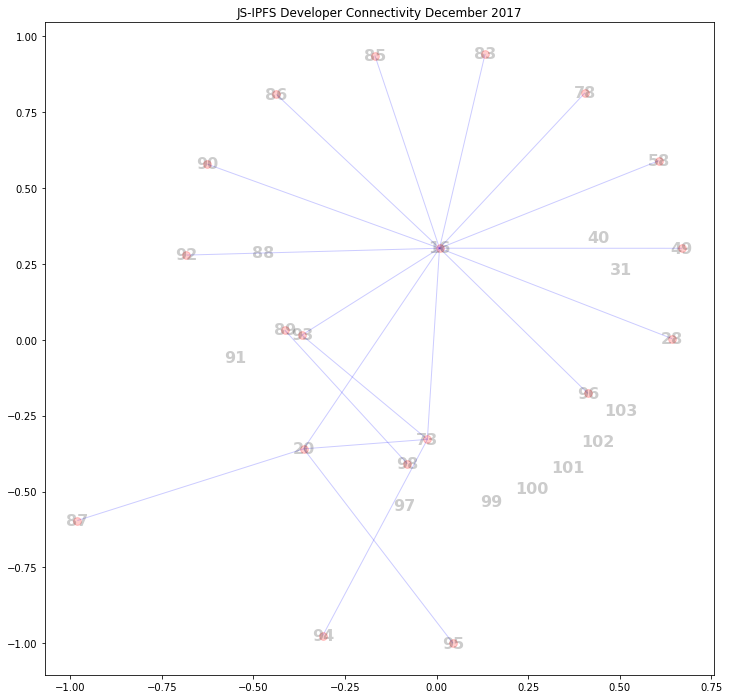

Graphing 2018
PERCENT EMPTY NODES  0.14492753623188406


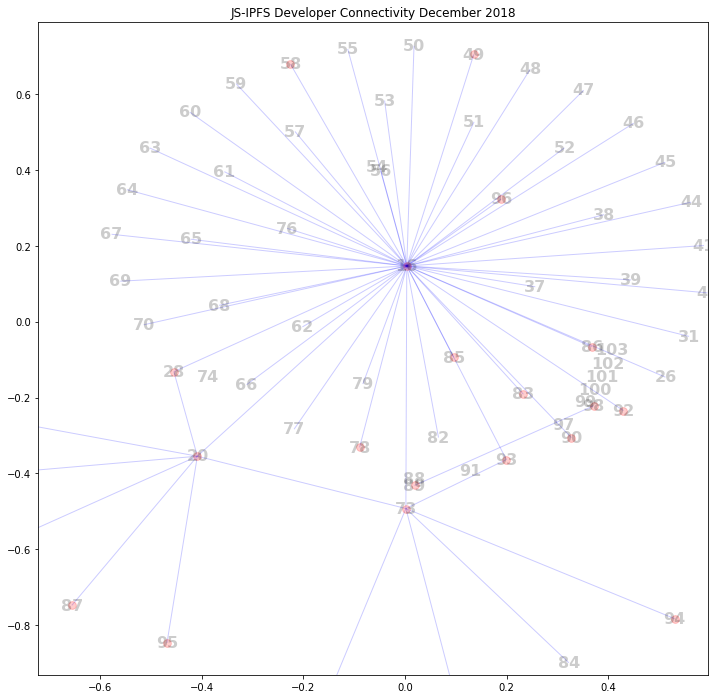

Graphing 2019
PERCENT EMPTY NODES  0.12643678160919541


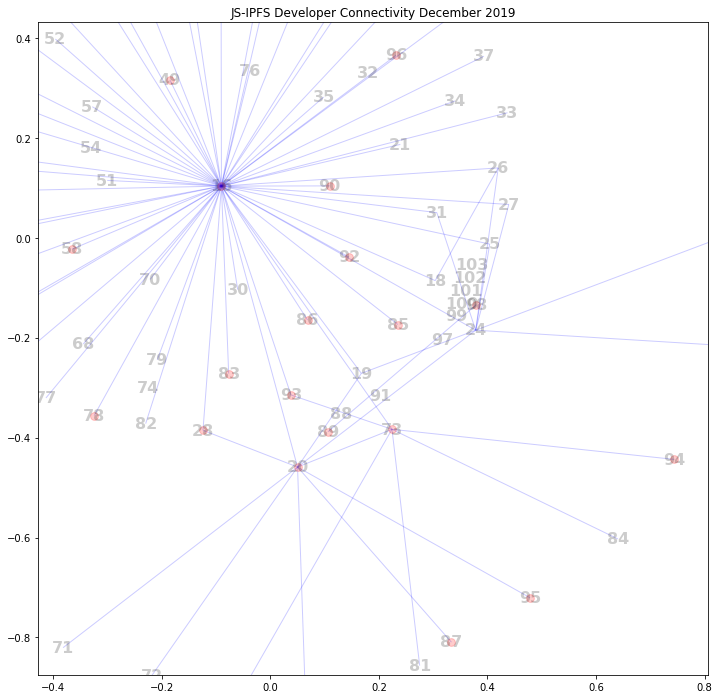

In [518]:
# generate
for year in [2017, 2018, 2019]:
    print('Graphing {}'.format(year))
    years_df = rank_df_alltime.loc[rank_df_alltime.rank_time.apply(lambda x: x.year < year), :]
    _, _, g = create_graph(years_df)
    graph_network_save_pdf(g, 'JS-IPFS Developer Connectivity December {}'.format(str(year)))


In [125]:
def get_monthly_totals(df1, start_date, end_date):
    if isinstance(end_date, str):
         end_date = pd.datetime.strptime(end_date, '%Y-%m-%d').date()
    if isinstance(start_date, str):
         start_date = pd.datetime.strptime(start_date, '%Y-%m-%d').date()
    mask = ((df1.date > start_date) & (df1.date < end_date))
    return df1[mask].groupby(['author_id']).agg({
    'additions': np.sum, 
    'deletions': np.sum,  
    'net_change': np.mean, 
    'code_complexity_max': np.max,
    'filename_old': 'nunique',
    'is_rename': np.sum, 
    'is_deletion': np.sum, 
    'is_new': np.sum,
    'diff_id': 'nunique', 
    'commit_id': 'nunique'}).rename(columns={
        'additions': 'total_additions', 
        'deletions': 'total_deletions', 
        'net_change': 'average_net_change',
        'code_complexity_max':'max_code_complexity', 
        'filename_old': 'num_unique_files_changed', 
        'is_rename': 'num_renames',
        'is_deletion': 'num_deletions',
        'is_new': 'num_new_files', 
        'commit_id': 'num_commits', 
        'diff_id': 'num_total_diffs'
    })

In [139]:
def compute_monthly_deltas(df1, start_date, end_date, cols_to_rank=None):
    # rank several important stats during the monthly period
    monthly_stats = get_monthly_totals(df1, start_date, end_date)
    
    ranks = rank_metrics(monthly_stats)
    df2 = monthly_stats.merge(right=ranks, left_index=True, right_index=True)
    df2['rank_start'] = start_date
    df2['rank_end'] = end_date
    df3 = df2.reset_index().rename(
        columns={'author_email': 'email', 'author_id': 'developer_id'})
    if df3.shape[0] == 0:
        print('start ', start_date)
    return df3.sort_values('rank')

In [140]:
date_range = list(funcy.pairwise(pd.date_range(start='06/01/2014', end='2018-07-01', freq='M')))

monthly_dfs = []
for start, end in date_range:
    monthly_dfs.append(compute_monthly_deltas(df3, start.date(), end.date()))

ranking the following columns  ['total_additions', 'total_deletions', 'average_net_change', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_deletions', 'num_new_files', 'num_total_diffs', 'num_commits']
ranking the following columns  ['total_additions', 'total_deletions', 'average_net_change', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_deletions', 'num_new_files', 'num_total_diffs', 'num_commits']
ranking the following columns  ['total_additions', 'total_deletions', 'average_net_change', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_deletions', 'num_new_files', 'num_total_diffs', 'num_commits']
start  2014-08-31
ranking the following columns  ['total_additions', 'total_deletions', 'average_net_change', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_deletions', 'num_new_files', 'num_total_diffs', 'num_commits']
start  2014-09-30
ranking the following columns  ['total_additions', 'total_de

ranking the following columns  ['total_additions', 'total_deletions', 'average_net_change', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_deletions', 'num_new_files', 'num_total_diffs', 'num_commits']
ranking the following columns  ['total_additions', 'total_deletions', 'average_net_change', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_deletions', 'num_new_files', 'num_total_diffs', 'num_commits']
ranking the following columns  ['total_additions', 'total_deletions', 'average_net_change', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_deletions', 'num_new_files', 'num_total_diffs', 'num_commits']
ranking the following columns  ['total_additions', 'total_deletions', 'average_net_change', 'code_complexity_max', 'num_unique_files_changed', 'num_renames', 'num_deletions', 'num_new_files', 'num_total_diffs', 'num_commits']
ranking the following columns  ['total_additions', 'total_deletions', 'average_net_change', 'cod

In [137]:
start, end = ['2018-01-01', '2018-02-01']
df3.loc[((df3.date < pd.datetime.strptime(end, '%Y-%m-%d').date()) &
             (df3.date > pd.datetime.strptime(start, '%Y-%m-%d').date()))].author_id.unique()

array([37, 16, 26, 41, 43, 28, 35])

In [144]:
monthly_rank_df = pd.concat(
    monthly_dfs, axis=0, join='outer').reset_index(drop=True).sort_values(['developer_id', 'rank_start']).rename(columns={'author_id': 'developer_id'})
print(monthly_rank_df.shape)

print(monthly_rank_df.loc[pd.isnull(monthly_rank_df.developer_id)].shape)

(221, 25)
(0, 25)


In [143]:
if EXPORT_CSV:
    monthly_rank_df.to_csv(os.path.join(DROPBOX_DIR, 'developer_metrics_monthly.csv'))

In [379]:
monthly_rank_df.columns


Index(['developer_id', 'total_additions', 'total_deletions',
       'average_net_change', 'code_complexity_max', 'num_unique_files_changed',
       'num_renames', 'num_deletions', 'num_new_files', 'num_total_diffs',
       'num_commits', 'rank_total_additions', 'rank_total_deletions',
       'rank_average_net_change', 'rank_code_complexity_max',
       'rank_num_unique_files_changed', 'rank_num_renames',
       'rank_num_deletions', 'rank_num_new_files', 'rank_num_total_diffs',
       'rank_num_commits', 'avg_rank', 'rank', 'rank_start', 'rank_end'],
      dtype='object')

## Developer Ranking by Code Contribution

* rank column - this is a developer's overall rank by contributions to the specific repository
* todal diffs - total number of diffs committed to the repo
* total_additions - total number of lines added to the code base
* total_deletions - total lines deleted from the code base
* average_net_change - average net change by lines of code in their contributions
* mean_of_code_complexity_median - average median code complexity of lines added
* average_max_code_complexity - average (per diff) of the max code complexity of lines added
* avg_num_unique_files_changed - average unique files changed per diff
* avg_num_edit_locations - average edit locations per diff. Can be interpreted as number of unique code changes per diff
* num_renames - number of files renamed
* num_deletions - number of files deleted
* num_new_files - number of files created
* avg_net_code_per_diff - average additions-deletions of code per diff
* first_author_engagement - date of first engagement as a commit author with repo
* last_author_engagement - date of last engagement as a commit author with repo
* num_authored_commits - number of commits authored 
* first_commiter_engagement - date of first engagement as a committer with repo
* last_commiter_engagement - date of last engagement as a committer with repo
* num_commiter_commits - number of commits committed
* people_who_committer_their_commits' - list of author ids of distinct people who committed commits they authored
* people_who_authored_commits_they_commited' - ids of distinct people who authored commits they commited
* email - github account email
* name - github account name
* num_other_commiters - number of people who commited things they authored
* num_other_authors - number of people who authored commits they commited
* len_author_engagement - time in days between first and last engagement as commit author
* len_commiter_engagement - length of time in days of engagement as a commiter
* number_different_files_changed - total number of different files changed
* avg_num_distinct_authors_per_file - for files they changed, average number of developers contributing to that file
* average_pct_additions - for files they have worked on, average percent of total lines they added
* avg_pct_deletions - for files they have worked on, average percent of total lines they deleted
* avg_file_age - average days since file they worked on was last changed
* total_files_solo_authored - total number of files they are solo author of
* total_files_with_max_complexity - total number of files they contributed code equal to the max complexity of the file
* total_files_more_than_50pct_additions - total number of files where they contributed more than 50% of the code
* total_files_more_than_50pct_deletions- total number of files where they deleted more than 50% of the code
* total_files_with_last_change - total number of files where their change was last one
* type_first_engagement - first type of engagement (as author or commiter)
* type_last_engagement - last type of engagement (as author or commiter)
* time_involved - days between first/last engagement of any type
       
  
  
After computing these numerical stats, I rank each developer on the stat, then I take an equal weighted average of the ranks for the "avg_rank") and then rank developers on their average rank to figure out who has the best constribution over time. 

## Rolling Average Developer Ranks


* todal diffs - total number of diffs committed to the repo
* total_additions - total number of lines added to the code base
* total_deletions - total lines deleted from the code base
* average_net_change - average net change by lines of code in their contributions
* mean_of_code_complexity_median - average median code complexity of lines added
* average_max_code_complexity - average (per diff) of the max code complexity of lines added
* avg_num_unique_files_changed - average unique files changed per diff

* avg_num_edit_locations - average edit locations per diff. Can be interpreted as number of unique code changes per diff
* num_renames - number of files renamed
* num_deletions - number of files deleted
* num_new_files - number of files created

* avg_net_code_per_diff - average additions-deletions of code per diff

* num_authored_commits - number of commits authored 

* num_commiter_commits - number of commits committed
* people_who_committer_their_commits' - list of author ids of distinct people who committed commits they authored
* people_who_authored_commits_they_commited' - ids of distinct people who authored commits they commited


* num_other_commiters - number of people who commited things they authored
* num_other_authors - number of people who authored commits they commited

* len_author_engagement - time in days between first and last engagement as commit author
* len_commiter_engagement - length of time in days of engagement as a commiter

* number_different_files_changed - total number of different files changed


* avg_file_age - average days since file they worked on was last changed
* files_solo_authored - total number of files they are solo author of
* files_with_max_complexity - total number of files they contributed code equal to the max complexity of the file

* files_more_than_50pct_additions - total number of files where they contributed more than 50% of the code
* files_more_than_50pct_deletions- total number of files where they deleted more than 50% of the code
* files_with_last_change - total number of files where their change was last one


* type_first_engagement - first type of engagement (as author or commiter)
* type_last_engagement - last type of engagement (as author or commiter)

* flag for month when a developer is first engaged
       

### Delta Stats
How to identify new, high quality contributors?

What if we also looked at changes over time? For instance, can we compute a rolling average/mean/sum for these statistics?

Also, we should be able to identify new developers in each period  maybe also compute what was their first activity like - rate of change? How quickly they move up the ranks on some basic statistics?

maybe start with some very basic stats, compute a rolling average 
- look at how data comes in, what is the easiest way to do this?
Is it to modify some of the functions that compute statistics with a start and end date?


# then, check the ethereum go repo
Re run the stats on the etherum go repo
is there any other informaiton on developers to add into the datasets? For instance, can we download their affiliation from github?


# can we do a useful decomposition of the stats?
# or is there too much path dependence with the aggregate statistics?

